In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import seaborn as sn
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.utils import resample

nlp = spacy.blank('id')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
komentar = df['komentar'].astype(str)

# Huruf kecil
komentar = komentar.apply(lambda x: x.lower())

# Hapus URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# Hapus angka
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

# Hapus tanda baca
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Hapus diluar alphabet dan numeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

# Tokenizing data
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df['label'].value_counts()

negatif    1101
positif    1017
netral      997
Name: label, dtype: int64

In [5]:
df = df[df.komentar.astype(bool)]

df_pos = df[df['label'] == 'positif']
X_pos_text = df_pos['komentar']
y_pos_label = df_pos['label']

df_neg = df[df['label'] == 'negatif']
X_neg_text = df_neg['komentar']
y_neg_label = df_neg['label']

df_net = df[df['label'] == 'netral']
X_net_text = df_net['komentar']
y_net_label = df_net['label']

In [6]:
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos_text, y_pos_label, test_size=0.2, random_state=1, stratify=y_pos_label)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg_text, y_neg_label, test_size=0.2, random_state=1, stratify=y_neg_label)
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(X_net_text, y_net_label, test_size=0.2, random_state=1, stratify=y_net_label)

In [7]:
X_pos_train_down = resample(X_pos_train, replace=True, n_samples=int(len(X_neg_train)))
y_pos_train_down = resample(y_pos_train, replace=True, n_samples=int(len(y_neg_train)))

X_net_train_up = resample(X_net_train, replace=True, n_samples=int(len(X_neg_train)))
y_net_train_up = resample(y_net_train, replace=True, n_samples=int(len(y_neg_train)))

In [8]:
X_train = pd.concat([X_neg_train, X_pos_train_down])
X_train = pd.concat([X_train, X_net_train_up])
y_train = pd.concat([y_neg_train, y_pos_train_down])
y_train = pd.concat([y_train, y_net_train_up])

X_test = pd.concat([X_neg_test, X_pos_test])
X_test = pd.concat([X_test, X_net_test])
y_test = pd.concat([y_neg_test, y_pos_test])
y_test = pd.concat([y_test, y_net_test])

In [9]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [10]:
print(y_train.value_counts())

positif    880
netral     880
negatif    880
Name: label, dtype: int64


In [11]:
model = FastText.load('Model/XGBUpDownSampling.bin')

In [12]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [13]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [14]:
lc = preprocessing.LabelEncoder()
lc.fit(y_train)

LabelEncoder()

In [15]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [16]:
train=xgb.DMatrix(X_train_vector,label=y_train_enc)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

In [17]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.5
# Max Depth:  12
# Subsample:  0.4
# Colsample Bytree:  0.3
# Alpha:  0.01
# Lamda:  2
# Min Child Weight:  3
# Number of Trees:  1000

# Learning Rate:  0.01
# Gamma:  0.1
# Max Depth:  10
# Subsample:  0.7
# Colsample Bytree:  1.0
# Alpha:  1
# Lamda:  1
# Min Child Weight:  5
# Number of Trees:  1000

param['num_class']=len(set(y_train))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.1
param['max_depth'] = 10
param['subsample'] = 0.7
param['colsample_bytree'] = 1
param['reg_alpha'] = 1
param['reg_lambda'] = 1
param['min_child_weight'] = 5
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.20303	test-merror:0.53280
[1]	train-merror:0.12917	test-merror:0.52480
[2]	train-merror:0.08977	test-merror:0.53280
[3]	train-merror:0.06591	test-merror:0.50400
[4]	train-merror:0.05379	test-merror:0.48000
[5]	train-merror:0.04546	test-merror:0.49920
[6]	train-merror:0.03977	test-merror:0.51200
[7]	train-merror:0.03750	test-merror:0.52000
[8]	train-merror:0.03523	test-merror:0.49120
[9]	train-merror:0.03182	test-merror:0.49280
[10]	train-merror:0.03030	test-merror:0.49120
[11]	train-merror:0.02652	test-merror:0.48160
[12]	train-merror:0.02727	test-merror:0.48640
[13]	train-merror:0.02652	test-merror:0.47680
[14]	train-merror:0.02614	test-merror:0.47360
[15]	train-merror:0.02576	test-merror:0.46080
[16]	train-merror:0.02235	test-merror:0.47040
[17]	train-merror:0.02083	test-merror:0.46880
[18]	train-merror:0.02046	test-merror:0.46880
[19]	train-merror:0.02121	test-merror:0.48480
[20]	train-merror:0.02083	test-merror:0.48160
[21]	train-merror:0.01894	test-merror:0.4720

[177]	train-merror:0.00189	test-merror:0.44000
[178]	train-merror:0.00189	test-merror:0.43840
[179]	train-merror:0.00189	test-merror:0.44000
[180]	train-merror:0.00189	test-merror:0.44160
[181]	train-merror:0.00189	test-merror:0.44320
[182]	train-merror:0.00189	test-merror:0.44160
[183]	train-merror:0.00152	test-merror:0.44480
[184]	train-merror:0.00152	test-merror:0.44160
[185]	train-merror:0.00189	test-merror:0.44320
[186]	train-merror:0.00189	test-merror:0.44320
[187]	train-merror:0.00189	test-merror:0.44320
[188]	train-merror:0.00152	test-merror:0.44160
[189]	train-merror:0.00189	test-merror:0.44160
[190]	train-merror:0.00152	test-merror:0.44000
[191]	train-merror:0.00152	test-merror:0.43840
[192]	train-merror:0.00152	test-merror:0.43680
[193]	train-merror:0.00152	test-merror:0.44000
[194]	train-merror:0.00152	test-merror:0.44320
[195]	train-merror:0.00152	test-merror:0.44480
[196]	train-merror:0.00152	test-merror:0.44160
[197]	train-merror:0.00152	test-merror:0.44320
[198]	train-m

[352]	train-merror:0.00038	test-merror:0.43040
[353]	train-merror:0.00038	test-merror:0.42880
[354]	train-merror:0.00038	test-merror:0.42720
[355]	train-merror:0.00038	test-merror:0.42720
[356]	train-merror:0.00038	test-merror:0.42880
[357]	train-merror:0.00038	test-merror:0.42880
[358]	train-merror:0.00038	test-merror:0.42720
[359]	train-merror:0.00038	test-merror:0.42880
[360]	train-merror:0.00038	test-merror:0.42880
[361]	train-merror:0.00038	test-merror:0.42880
[362]	train-merror:0.00038	test-merror:0.42880
[363]	train-merror:0.00038	test-merror:0.42560
[364]	train-merror:0.00038	test-merror:0.42720
[365]	train-merror:0.00038	test-merror:0.42720
[366]	train-merror:0.00038	test-merror:0.42560
[367]	train-merror:0.00038	test-merror:0.42720
[368]	train-merror:0.00038	test-merror:0.42880
[369]	train-merror:0.00038	test-merror:0.42880
[370]	train-merror:0.00038	test-merror:0.42880
[371]	train-merror:0.00038	test-merror:0.42880
[372]	train-merror:0.00038	test-merror:0.43040
[373]	train-m

[527]	train-merror:0.00000	test-merror:0.42880
[528]	train-merror:0.00000	test-merror:0.42880
[529]	train-merror:0.00000	test-merror:0.42880
[530]	train-merror:0.00000	test-merror:0.42880
[531]	train-merror:0.00000	test-merror:0.43040
[532]	train-merror:0.00000	test-merror:0.42880
[533]	train-merror:0.00000	test-merror:0.43040
[534]	train-merror:0.00000	test-merror:0.43200
[535]	train-merror:0.00000	test-merror:0.43040
[536]	train-merror:0.00000	test-merror:0.42880
[537]	train-merror:0.00000	test-merror:0.42880
[538]	train-merror:0.00000	test-merror:0.42880
[539]	train-merror:0.00000	test-merror:0.42880
[540]	train-merror:0.00000	test-merror:0.43040
[541]	train-merror:0.00000	test-merror:0.43200
[542]	train-merror:0.00000	test-merror:0.43200
[543]	train-merror:0.00000	test-merror:0.43040
[544]	train-merror:0.00000	test-merror:0.43040
[545]	train-merror:0.00000	test-merror:0.43040
[546]	train-merror:0.00000	test-merror:0.42880
[547]	train-merror:0.00000	test-merror:0.43200
[548]	train-m

[702]	train-merror:0.00000	test-merror:0.43040
[703]	train-merror:0.00000	test-merror:0.43040
[704]	train-merror:0.00000	test-merror:0.43040
[705]	train-merror:0.00000	test-merror:0.43200
[706]	train-merror:0.00000	test-merror:0.43200
[707]	train-merror:0.00000	test-merror:0.43200
[708]	train-merror:0.00000	test-merror:0.43200
[709]	train-merror:0.00000	test-merror:0.43200
[710]	train-merror:0.00000	test-merror:0.43200
[711]	train-merror:0.00000	test-merror:0.43200
[712]	train-merror:0.00000	test-merror:0.43200
[713]	train-merror:0.00000	test-merror:0.43200
[714]	train-merror:0.00000	test-merror:0.43200
[715]	train-merror:0.00000	test-merror:0.43200
[716]	train-merror:0.00000	test-merror:0.43040
[717]	train-merror:0.00000	test-merror:0.43040
[718]	train-merror:0.00000	test-merror:0.43200
[719]	train-merror:0.00000	test-merror:0.43200
[720]	train-merror:0.00000	test-merror:0.43200
[721]	train-merror:0.00000	test-merror:0.43200
[722]	train-merror:0.00000	test-merror:0.43200
[723]	train-m

[877]	train-merror:0.00000	test-merror:0.43040
[878]	train-merror:0.00000	test-merror:0.43200
[879]	train-merror:0.00000	test-merror:0.43200
[880]	train-merror:0.00000	test-merror:0.43040
[881]	train-merror:0.00000	test-merror:0.43040
[882]	train-merror:0.00000	test-merror:0.43040
[883]	train-merror:0.00000	test-merror:0.43040
[884]	train-merror:0.00000	test-merror:0.43040
[885]	train-merror:0.00000	test-merror:0.43040
[886]	train-merror:0.00000	test-merror:0.43040
[887]	train-merror:0.00000	test-merror:0.43040
[888]	train-merror:0.00000	test-merror:0.43200
[889]	train-merror:0.00000	test-merror:0.43040
[890]	train-merror:0.00000	test-merror:0.43040
[891]	train-merror:0.00000	test-merror:0.43040
[892]	train-merror:0.00000	test-merror:0.43040
[893]	train-merror:0.00000	test-merror:0.43040
[894]	train-merror:0.00000	test-merror:0.43200
[895]	train-merror:0.00000	test-merror:0.43200
[896]	train-merror:0.00000	test-merror:0.43200
[897]	train-merror:0.00000	test-merror:0.43200
[898]	train-m

In [18]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [19]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.568 

Train Score
 1.0 

CONFUSSION MATRIX
 [[171  31  19]
 [ 89  83  28]
 [ 66  37 101]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.52      0.77      0.63       221
      netral       0.55      0.41      0.47       200
     positif       0.68      0.50      0.57       204

    accuracy                           0.57       625
   macro avg       0.59      0.56      0.56       625
weighted avg       0.58      0.57      0.56       625
 



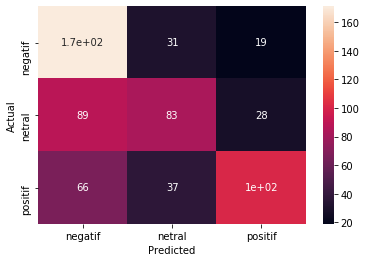

In [21]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [22]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])